# Azure OpenAI Assistants - Code Interpreter

File Formats: https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/code-interpreter?tabs=python

This notebook will find answers to a data set:
1. If 1 row in the dataset is 1 sighthing, what's our total sightings?
2. Which state has the most sightings?
3. Which season has the most sightings?
4. What are the top 10 years with the most sightings?
5. How many sightings did we have for Washington state in the year 2000?

Answers:
1. 5021
2. Washington (601)
3. Summer
4. 2004, 2005, 2006, 2003, 2000, 2007, 2008, 2012, 2001, 2011
5. 28

## Install Dependencies

In [ ]:
%pip install openai

## Load Azure Configuration

In [1]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Step 1-2:
1. Create an Assistant
2. Create a Thread

In [2]:
from openai import AzureOpenAI
import time

# Create an AzureOpenAI client
client = AzureOpenAI(
  azure_endpoint = azure_openai_endpoint,
  api_key= azure_openai_key,
  api_version=azure_openai_api_version
)

# Create a file
file = client.files.create(
  file=open("../Data/assistant/bigfootsightings.csv", "rb"),
  purpose='assistants'
)

# STEP 1: Create an assistant
assistant = client.beta.assistants.create(
  model=azure_openai_deployment,
  name="bigfootsightings",
  instructions="""You are an assistant answering questions about bigfootsightings dataset.""",
  tools=[{"type":"code_interpreter"}],
  tool_resources={"code_interpreter":{"file_ids":[file.id]}},
  temperature=1,
  top_p=1, 
)

# STEP 2: Create a thread
thread = client.beta.threads.create()


## Step 3-6: Helper Function
3. Add a message to the thread
4. Run the Assistant
5. Check the Run Status
6. Display the Assistant's Response

In [3]:
from PIL import Image

def run_assistant(user_question):
  PROMPT_SUFFIX = """
  - **ALWAYS** before giving the Final Answer, try another method.
  Then reflect on the answers of the two methods you did and ask yourself
  if it answers correctly the original question.
  If you are not sure, try another method.
  - If the methods tried do not give the same result,reflect and
  try again until you have two methods that have the same result.
  - If you still cannot arrive to a consistent result, say that
  you are not sure of the answer.
  - If you are sure of the correct answer, create a beautiful
  and thorough response using Markdown.
  - **DO NOT MAKE UP AN ANSWER OR USE PRIOR KNOWLEDGE,
  ONLY USE THE RESULTS OF THE CALCULATIONS YOU HAVE DONE**.
  - **ALWAYS**, as part of your "Final Answer", explain how you got
  to the answer on a section that starts with: "\n\nExplanation:\n".
  In the explanation, mention the column names that you used to get
  to the final answer and provide the python code you used.
  """

  # STEP 3: Add a user question to the thread
  messages = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content=PROMPT_SUFFIX + user_question
  )

  # STEP 4: Run the thread
  run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
  )

  # STEP 5: Check the run status
  # Looping until the run completes or fails
  while run.status in ['queued', 'in_progress', 'cancelling']:
    time.sleep(1)
    run = client.beta.threads.runs.retrieve(
      thread_id=thread.id,
      run_id=run.id
    )
    
    #display run status
    print(run.status)

    if run.status == 'completed':
      messages = client.beta.threads.messages.list(thread_id=thread.id)
      # STEP 6: Display the Assistant's Response
      content_block = messages.data[0].content[0]
      
      # Check if the content block has a text attribute
      if hasattr(content_block, 'text') and content_block.text.value is not None:
        print(content_block.text.value)
        
        # Check if the content block has an annotations attribute
        if hasattr(content_block.text, 'annotations') and len(content_block.text.annotations) > 0:
          # enter the file_id inside content example: "assistant-fYrZ85PwbViKU9mrVoE8dqBO"
          file_id = content_block.text.annotations[0].file_path.file_id
          image_data = client.files.content(file_id)
          image= image_data.write_to_file("img_code_interpreter.png")
          
          # Display the image in the default image viewer
          image = Image.open("img_code_interpreter.png")
          image.show()
      
      # Check if the content block has an image_file attribute
      if hasattr(content_block, 'image_file'):
        file_id = content_block.image_file.file_id
        image_data = client.files.content(file_id)
        image= image_data.write_to_file("img_code_interpreter.png")
          
        # Display the image in the default image viewer
        image = Image.open("img_code_interpreter.png")
        image.show()

    elif run.status == 'requires_action':
      # the assistant requires calling some functions
      # and submit the tool outputs back to the run
      pass

    elif run.status == "failed":
        print(run.last_error)
        
    else:
      pass
    


In [4]:
user_query = "If 1 row in the dataset is 1 sighting, what's our total sightings?"
run_assistant(user_query)

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed
# Total Bigfoot Sightings

The dataset contains **5021** rows, and since 1 row corresponds to 1 sighting, there are a total of **5021 Bigfoot sightings** in this dataset.

### Explanation:

I loaded the dataset and observed the structure of the data. The number of rows in the dataset is determined by using the `.shape` attribute of the dataframe, which gives the dimensions of the dataset. The first value of this attribute indicates the number of rows.

**Python Code:**
```python
import pandas as pd

# Load the uploaded file
file_path = "/mnt/data/assistant-3nN5LdeEE9QAfMbQ9uoWhv"
df = pd.read_csv(file_path)

# Check the total number of rows in the dataset, as 1 row corresponds to 1 sighting
total_sightings = df.shape[0]
total_sightings
```
The output confirms that there are 5021 rows, thus 5021 Bigfoot sightings in this dataset.


## Step 7: Appending Messages to the thread

In [5]:
user_query ="""Which state has the most sightings? Provide the number of sightings in that state"""
run_assistant(user_query)

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed
### State with the Most Bigfoot Sightings

The state with the most Bigfoot sightings is **Washington**, with a total of **601 sightings**.

### Explanation:

To determine which state has the most Bigfoot sightings, I used two methods:
1. **Using `value_counts` Method**:
   - I used the `value_counts()` function on the `state` column to count the number of sightings per state.
   - I then used `.idxmax()` to determine the state with the highest number of sightings and `.max()` to get the count of sightings in that state.

2. **Using `groupby` and `size` Methods**:
   - I grouped the data by the `state` column using `groupby` and then counted the number of sightings in each group using `size()`.
   - I reset the index to make it easier to access, then used `.idxmax()` on the `counts` column to find the state with the highest number of sightings and retrieved the correspon

In [6]:
user_query ="""Which season has the most sightings?"""
run_assistant(user_query)

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed
### Season with the Most Bigfoot Sightings

The season with the most Bigfoot sightings is **Summer**, with a total of **1867 sightings**.

### Explanation:

To determine which season has the most Bigfoot sightings, I used two methods:

1. **Using `value_counts` Method**:
   - I used the `value_counts()` function on the `season` column to count the number of sightings per season.
   - I then used `.idxmax()` to determine the season with the highest number of sightings and `.max()` to get the count of sightings in that season.

2. **Using `groupby` and `size` Methods**:
   - I grouped the data by the `season` column using `groupby` and then counted the number of sightings in each group using `size()`.
   - I reset the index to make it easier to access, then used `.idxmax()` on the `counts` column to find the season with the highest number of sightings and retrieved the corresponding 

in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
in_progress
completed


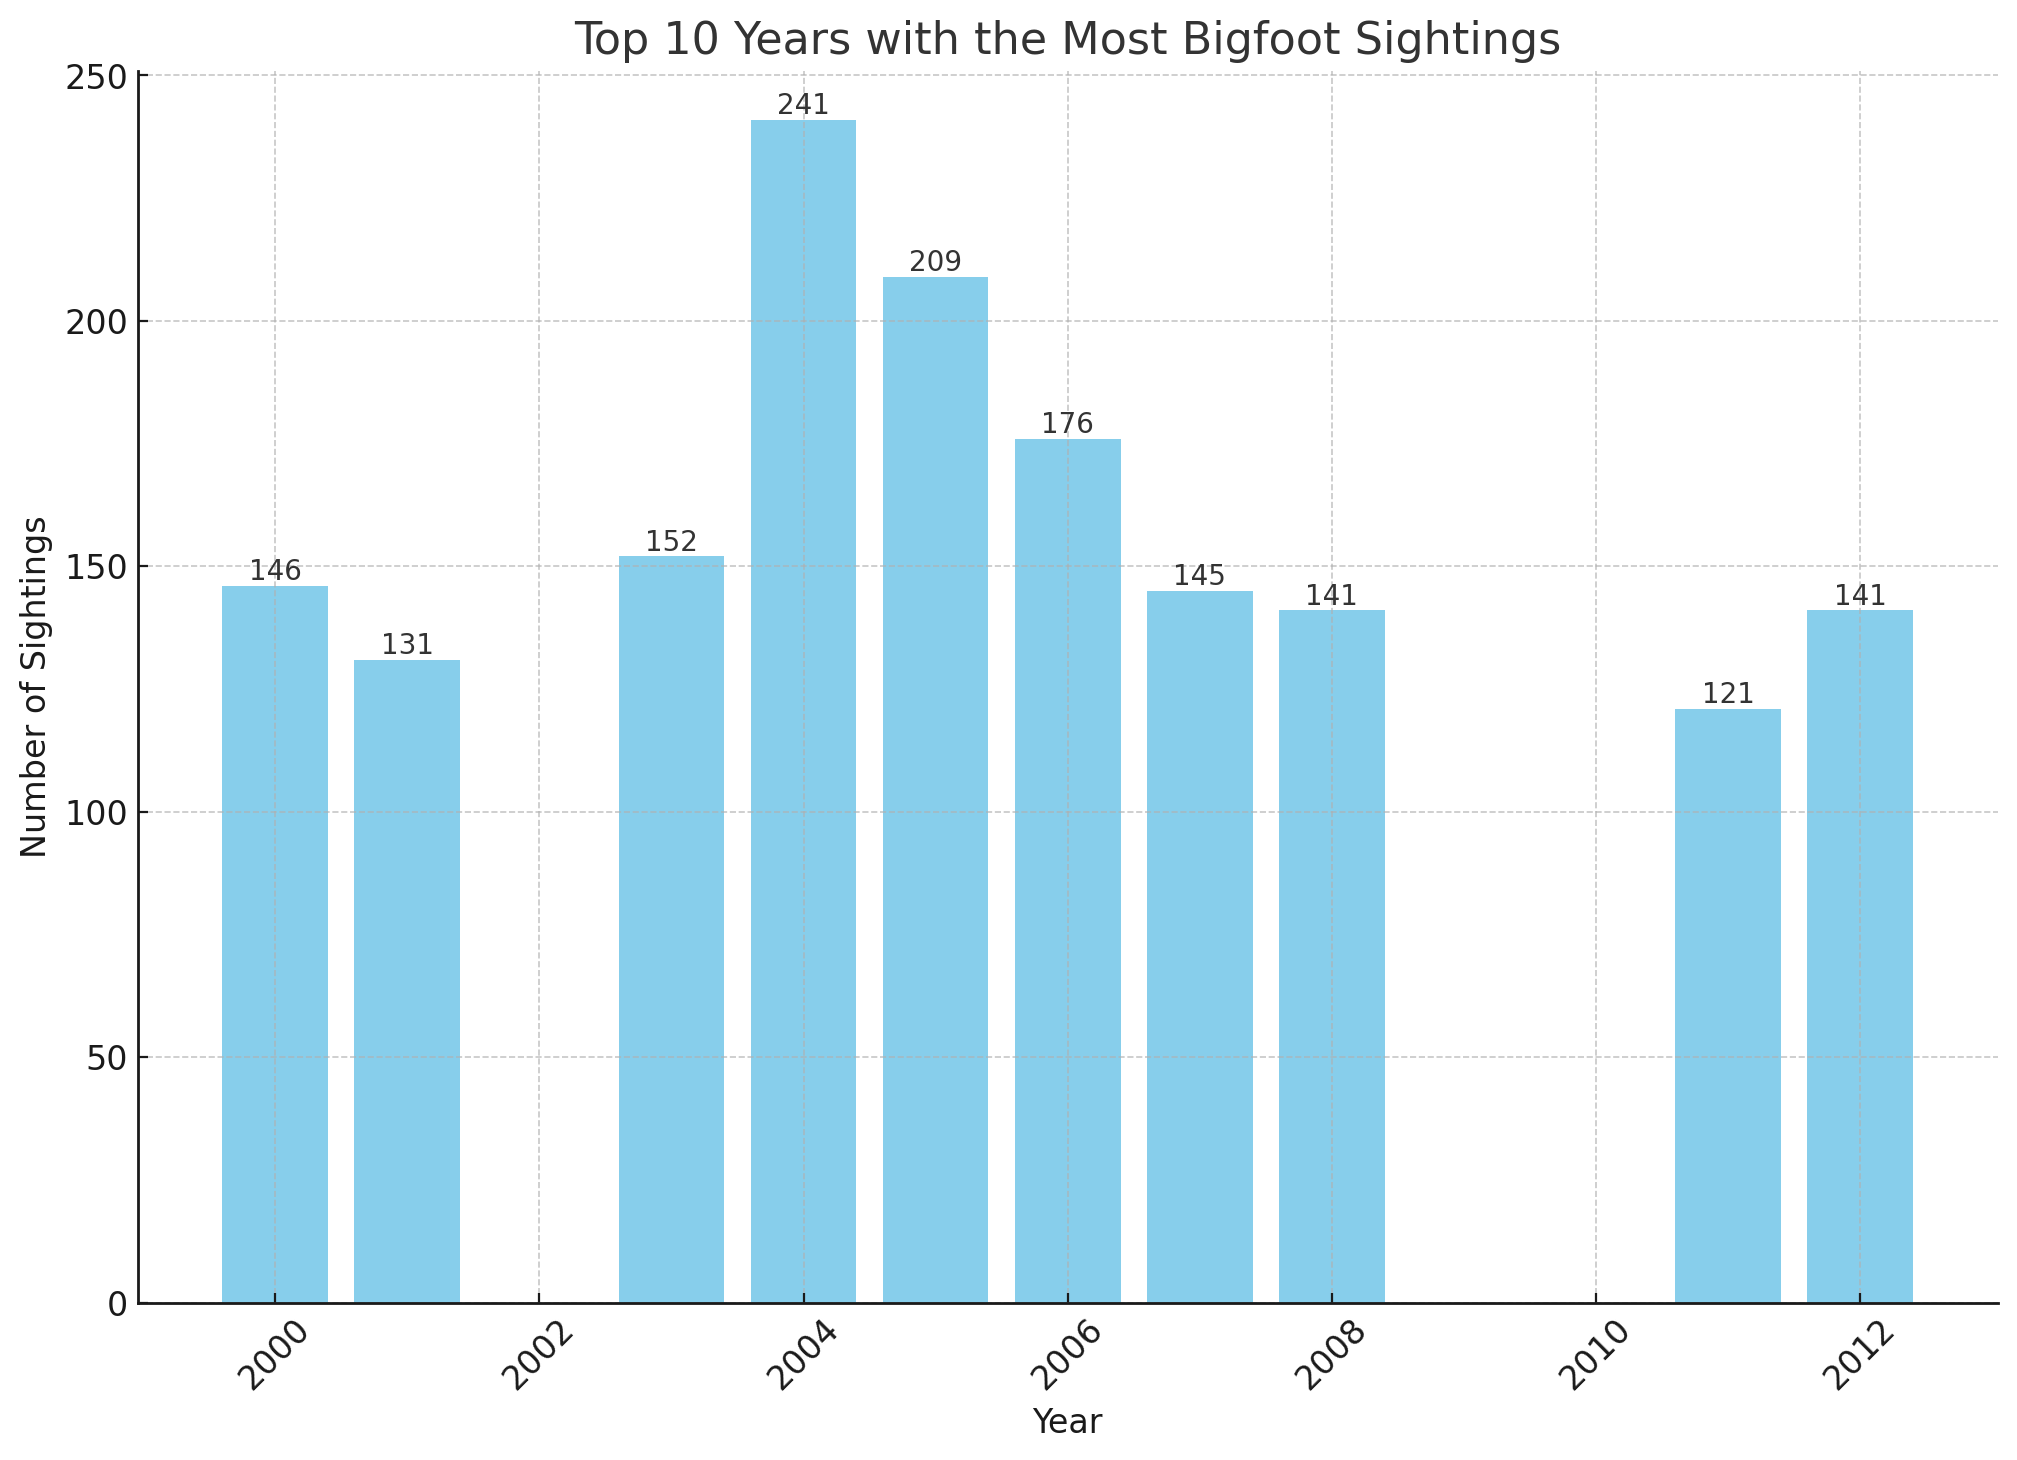

In [7]:
user_query ="""
What are the top 10 years with the most sightings? 
Use the date column and get the year there.
Create a column chart with the sightings in the Y-axis and years in the X-axis and save it to a PNG file and sort by descending order.
Put the value on top of each bar
"""
run_assistant(user_query)

## Delete Assistant

In [8]:
response = client.beta.assistants.delete(assistant.id)